# Generic pressure and temperature drop calculations

## import libraries

In [5]:
import thermo
import fluids
from shapely.geometry import Point, Polygon, LineString
import math
import pandas as pd
from tqdm import tqdm
from pprint import pprint

## Given Input Data

In [6]:
pArrival = 70e5 # wanted arrival pressure [bar]
CpSteel=2.29e3 #J/kg/K
kPipe = 45 #W/m/K
rhoWater = 1025 #kg/m3
muWater=0.00182 #viscosity of sea water [Pa*s]
kWater=0.56 # Thermal conductivity of sea water [W/m/K]
VWater= 0.2 # Velocity of sea water - current [m/s]
CpWater = 4300e3 # Specific heat capcity of water J/kg/K
Ta=4+273.15 # Ambient temperature deg K

# control points from the line
points = [{'x': 0.0, 'y': 0.12, 'z': 54.0546},
  {'x': 927.7, 'y': 32758.0, 'z': -99.0},
  {'x': -28471.08, 'y': 113337.86, 'z': -704.0},
  {'x': -55703.16, 'y': 165663.44, 'z': -1640.0},
  {'x': -39675.55, 'y': 171925.05, 'z': -1564.0}]
line_points =[(x["x"],x["y"],x["z"]) for x in points] 
path=LineString(line_points)

#fluid data
fluid = {
    "temperature": 110,
    "flowRateMMSCFD": 500,
    "pressure": 110e5
}
# here for simplification purpose we use only one line. 
line = { 'smys': 448000000.0,
 'points': points}
line["length"]= path.length
nearestMaterial = fluids.friction.nearest_material_roughness("steel tube",clean=False)
line["material"] = nearestMaterial
line["pipeRoughness"]= fluids.material_roughness(nearestMaterial)
line["corrosionAllowance"] = 0.003
odIn=30 # intial guess for OD
line["od"]=fluids.nearest_pipe(NPS=odIn,schedule="STD")[2]
line["id"]=fluids.nearest_pipe(NPS=odIn,schedule="STD")[1]
line["wallThickness"]=fluids.nearest_pipe(NPS=odIn,schedule="STD")[3]
print("Line data")
pprint(line)
print("Fluid data")
pprint(fluid)

Line data
{'corrosionAllowance': 0.003,
 'id': 0.74294,
 'length': 194741.37068050078,
 'material': 'Steel tubes, New',
 'od': 0.762,
 'pipeRoughness': 0.001,
 'points': [{'x': 0.0, 'y': 0.12, 'z': 54.0546},
            {'x': 927.7, 'y': 32758.0, 'z': -99.0},
            {'x': -28471.08, 'y': 113337.86, 'z': -704.0},
            {'x': -55703.16, 'y': 165663.44, 'z': -1640.0},
            {'x': -39675.55, 'y': 171925.05, 'z': -1564.0}],
 'smys': 448000000.0,
 'wallThickness': 0.009529999999999999}
Fluid data
{'flowRateMMSCFD': 500, 'pressure': 11000000.0, 'temperature': 110}


## Calculation

In [7]:
def calDropPT(S1,L=1):
    Tin=S1.T
    Pin=S1.P
    V = S1.Q/(math.pi/4*D**2)
    Re = S1.Reynolds(D=D, V=V)
    fd = fluids.friction_factor(Re=Re, eD=epsilon/D)
    Pout = fluids.isothermal_gas(rho=S1.rho, fd=fd, P1=S1.P, D=D, L=L, m=S1.m)
    for i in range(2):
        S2 = thermo.Stream('natural gas', P=0.5*(Pout+Pin), m=S1.m)
        V = S2.Q/(math.pi/4*D**2)
        Re = S2.Reynolds(D=D, V=V)
        fd = fluids.friction_factor(Re=Re, eD=epsilon/D)
        Pout = fluids.isothermal_gas(rho=S2.rho, fd=fd, P1=Pin, D=D, L=L, m=S1.m)
#         print('%g' %P2)
    Grashof = 9.81*(1/S1.T)*abs(S2.T-(Ta))*D**3/S2.nu**2
    mFl=S2.m # mass flowrate [kg/s]
    Cp=S2.Cp #Mass heat capacity [J/kg/K]
    Pr=S2.Pr # Prandtl number of the mixture at its current temperature, pressure, and phase; [dimensionless].
    R_Specific = S2.R_specific # Specific gas constant of the mixture, in units of [J/kg/K].
    Z= S2.Z # Compressibility factor of the mixture at its current phase and temperature and pressure, [dimensionless].
    k=S2.k # Thermal conductivity of the mixture at its current phase, temperature, and pressure in units of [W/m/K].
    nu=S2.nu # Kinematic viscosity of the the mixture at its current temperature, pressure, and phase in units of [m^2/s]
    mu=S2.mu # Viscosity of the mixture at its current phase, temperature, and pressure in units of [Pa*s]
    hi=0.023*Re**0.8*Pr**0.3*k/D # Inside film heat transfer coefficent [W/m2/K]
    Ri=OD/D/hi
    Rpipe=(OD*math.log(OD/D))/(2*kPipe)
    Rsurr=OD/(0.0266*kWater*(D*hi/k)**0.8*(rhoWater*VWater*OD/muWater)**0.33)
    Uo=1/(Ri+Rpipe+Rsurr)
    Ui=Uo*OD/D
    Tout = (Tin-Ta)/math.exp(Ui*math.pi*D*L/(mFl*Cp))+Ta
    
    results = {
        "segment length [m]":L, 
"mFl Mass flow rate [kg/s]":mFl,
"Pin Inlet Pressure [Pa]":Pin,
"Tin Inlet Fluid Temperature [K]":Tin,
"Pout Outlet Pressure [Pa]":Pout,
"Tout Outlet Fluid Temperature [K]":Tout,
"Average Gas velocity [m/s]":V,
"Re":Re,
"Grashof": Grashof,
"fd friction factor": fd,
"Cp Mass heat capacity [J/kg/K]":Cp,
"Pr Prandtl number":Pr,
"R_Scecific Specific gas constant  [J/kg/K]":R_Specific,
"Z Compressibility factor": Z,
"k Thermal conductivity [W/m/K]":k,
"nu Kinematic viscosity [m^2/s]":nu,
"mu Viscosity [Pa*s]":mu,
"hi Inside film heat transfer coefficent [W/m2/K]": hi,
"Ri Inside film resistance [m2*K/W]":Ri,
"Rpipe Pipewall resistance [m2*K/W]":Rpipe,
"RSurr Souranding film resistance [m2*K/W]":Rsurr,
"Uo Overall heat transfer coefficient [W/m2/K] on Pipe OD":Uo,
"Ui Overall heat transfer coefficient [W/m2/K] on Pipe ID":Ui
    }
    return Pout, Tout, results

Pstart = fluid["pressure"]
mmscfd=fluid["flowRateMMSCFD"]
Tstart=fluid["temperature"]+273.15
D=line["id"]
OD=line["od"]
totLength=line["length"]
L=1
epsilon = line["pipeRoughness"]
Qst = fluid["flowRateMMSCFD"]*1e6/(86400*35.3147) # mmscfd to m3/sec at standard coditions
S0=thermo.Stream('natural gas', T=15+273.15, P=101325, Q=Qst)
S1=thermo.Stream('natural gas', T=Tstart, P=Pstart, n=S0.n)
Pout, Tout, results = calDropPT(S1,L=1)
print(f"Flow rate of {mmscfd}MMSCFD, at standard condition 15 deg and 1 bar is {S0.Q}m3/s and {S0.m}kg/s,\n\
At actual cond with pressure {Pstart/1e5} bar and temperature {Tstart-273.15}deg are {S1.Q}m3/s and {S0.m}kg/s\n\n\
For pipe with ID {D*1000}mm, material {nearestMaterial} and roughness {epsilon}, flow rate of {mmscfd}MMSCFD \n\
pressure and temp change per unit length (m) are {Pout-Pstart}Pa {Tout-Tstart}K")

# m3/sec at actual coditions, needs to be in the iteration because temp, pressure and Z are fuction of p and T




/opt/anaconda3/lib/python3.7/site-packages/thermo/volume.py:437: RuntimeWarning: invalid value encountered in double_scalars
  - 0.81446*(1-Tr) + 0.190454*(1-Tr)**(4/3.)


Flow rate of 500MMSCFD, at standard condition 15 deg and 1 bar is 163.87048557787656m3/s and 116.74154605933394kg/s,
At actual cond with pressure 110.0 bar and temperature 110.0deg are 1.8750410115400888m3/s and 116.74154605933394kg/s

For pipe with ID 742.94mm, material Steel tubes, New and roughness 0.001, flow rate of 500MMSCFD 
pressure and temp change per unit length (m) are -11.115063305944204Pa -0.4546283672698337K


In [8]:
step = 1000
results=[]
for kp in tqdm(range(0,int(totLength),step)):
    PCur, TCur, result= calDropPT(S1,step)
    result["KP [m]"]=kp+step
    results.append(result)
#     print(f"At KP {kp+step} pressure is {PCur/1e5}bar and Temp is {TCur -273.15} degC")
    S1=thermo.Stream('natural gas', T=TCur, P=PCur, n=S0.n)
print(PCur)
df=pd.DataFrame(results)
df.head()   

100%|██████████| 195/195 [00:29<00:00,  6.57it/s]


8516303.113325886


,segment length [m],mFl Mass flow rate [kg/s],Pin Inlet Pressure [Pa],Tin Inlet Fluid Temperature [K],Pout Outlet Pressure [Pa],Tout Outlet Fluid Temperature [K],Average Gas velocity [m/s],Re,Grashof,fd friction factor,...,k Thermal conductivity [W/m/K],nu Kinematic viscosity [m^2/s],mu Viscosity [Pa*s],hi Inside film heat transfer coefficent [W/m2/K],Ri Inside film resistance [m2*K/W],Rpipe Pipewall resistance [m2*K/W],RSurr Souranding film resistance [m2*K/W],Uo Overall heat transfer coefficient [W/m2/K] on Pipe OD,Ui Overall heat transfer coefficient [W/m2/K] on Pipe ID,KP [m]
0,1000,116.741546,1.100000e+07,383.150000,1.098887e+07,278.591257,2.901061,1.788393e+07,1.518047e+13,0.021151,...,0.048704,1.205168e-07,0.000011,775.142151,0.001323,0.000214,0.000665,454.077262,465.726538,1000
1,1000,116.741546,1.098887e+07,278.591257,1.097773e+07,277.169606,2.904374,1.788393e+07,2.083029e+13,0.021151,...,0.048688,1.206545e-07,0.000011,774.962475,0.001323,0.000214,0.000665,454.024906,465.672838,2000
2,1000,116.741546,1.097773e+07,277.169606,1.096658e+07,277.150267,2.907699,1.788393e+07,2.088927e+13,0.021151,...,0.048672,1.207926e-07,0.000011,774.782619,0.001324,0.000214,0.000665,453.972481,465.619068,3000
3,1000,116.741546,1.096658e+07,277.150267,1.095542e+07,277.150004,2.911036,1.788393e+07,2.084287e+13,0.021151,...,0.048656,1.209312e-07,0.000011,774.602614,0.001324,0.000214,0.000664,453.919997,465.565238,4000
4,1000,116.741546,1.095542e+07,277.150004,1.094424e+07,277.150000,2.914384,1.788393e+07,2.079503e+13,0.021151,...,0.048640,1.210703e-07,0.000011,774.422461,0.001324,0.000214,0.000664,453.867455,465.511347,5000


## Plot Results

In [9]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

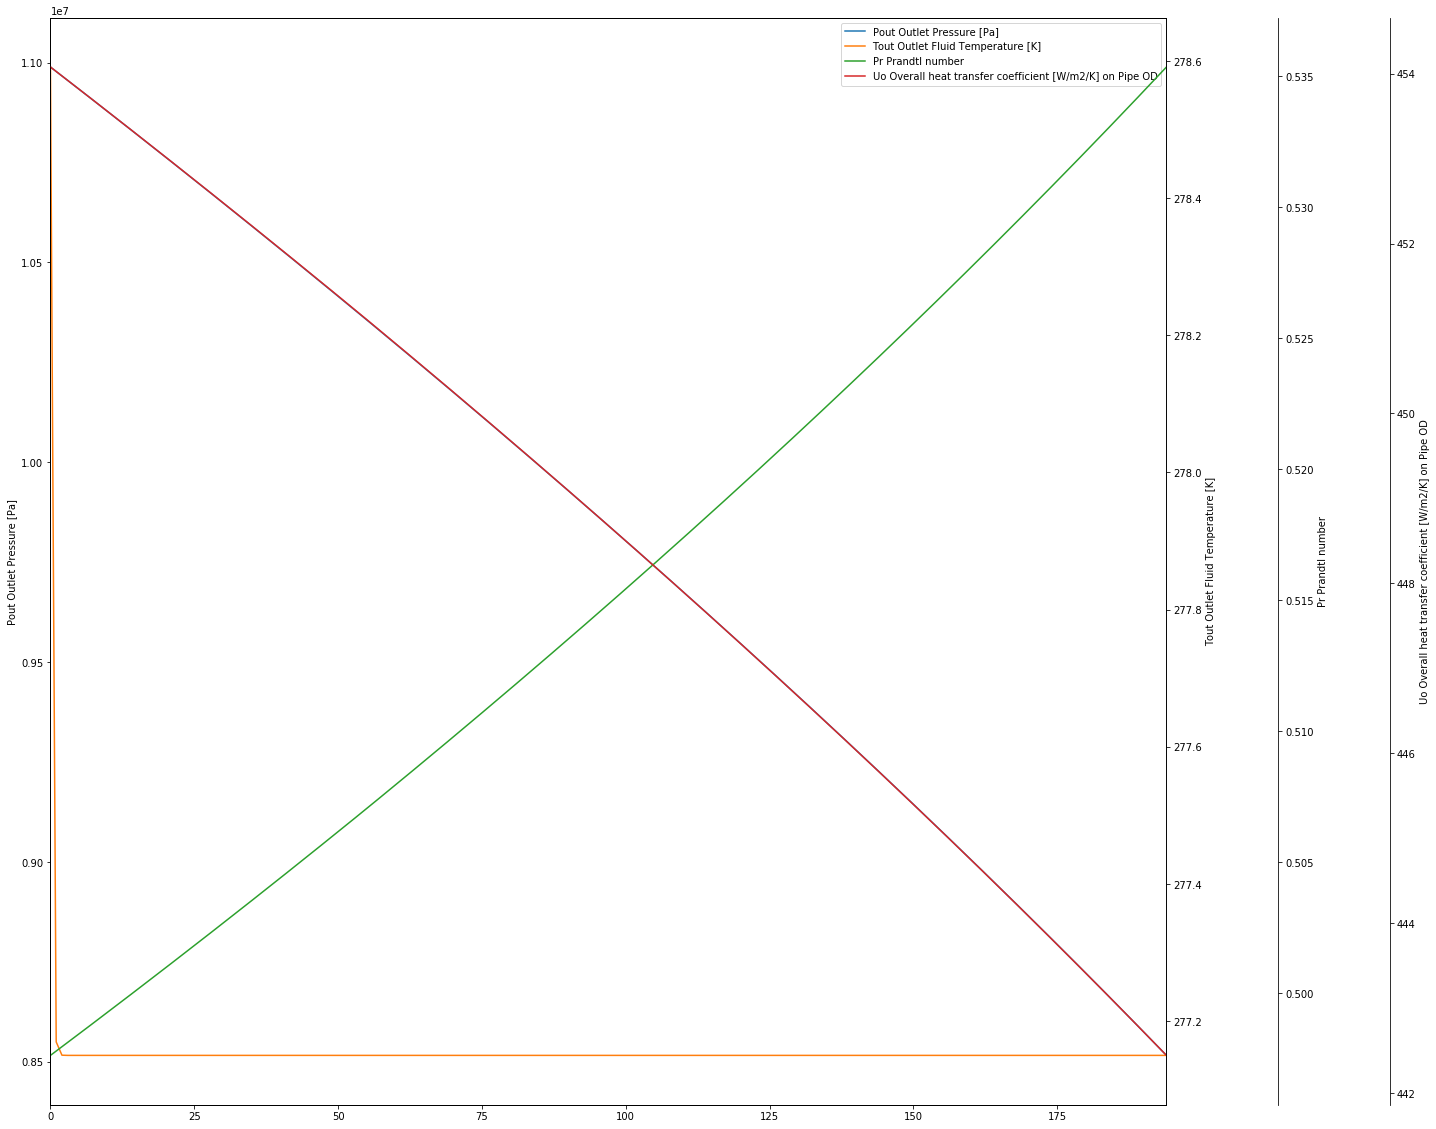

In [10]:
# _df = df[["KP","Segment outlet Pressure [Pa]", "Segment outlet temp [deg C]","Average Gas velocity [m/s]", "Pr Prandtl number", "Uo Overall heat transfer coefficient [W/m2/K] "]]
plot_multi(df,["Pout Outlet Pressure [Pa]", "Tout Outlet Fluid Temperature [K]", \
               "Pr Prandtl number", "Uo Overall heat transfer coefficient [W/m2/K] on Pipe OD"], figsize=(20,20))

<Figure size 1440x720 with 0 Axes>

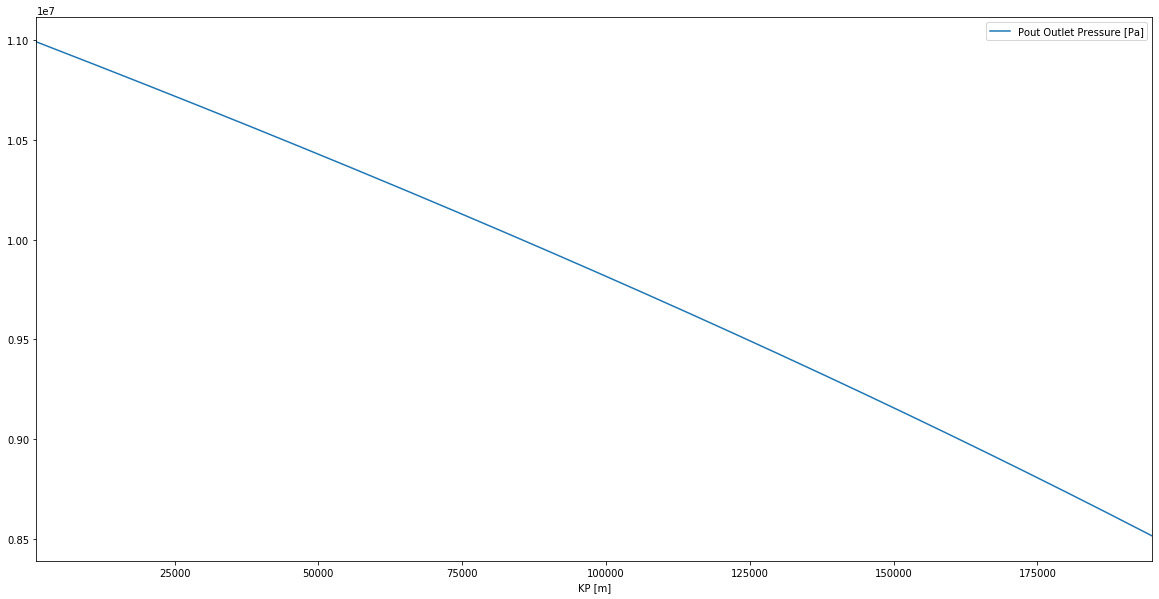

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# sns.lineplot(x="KP", y=["Segment outlet Pressure [Pa]", "Segment outlet temp [deg C]"], data=df)
df.plot(x="KP [m]", y=["Pout Outlet Pressure [Pa]"], figsize=(20,10))

In [12]:
df.to_excel("Ideal Gas Calculation results.xlsx")

In [13]:
S0

<Stream, components=['methane', 'nitrogen', 'carbon dioxide', 'ethane', 'propane', 'isobutane', 'butane', '2-methylbutane', 'pentane', 'hexane'], mole fractions=[0.9652, 0.0026, 0.006, 0.0182, 0.0046, 0.001, 0.001, 0.0005, 0.0003, 0.0007], mole flow=6949.369414107328 mol/s, T=288.15 K, P=101325 Pa>